# Basic Cirq features

Here we get aquainted with some basic Cirq features. First import the relevant packages:

In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import sympy # This is useful for defining parameters as symbols that can be iterated over

There are several ways to initialize qubits in Cirq:

In [4]:
q0 = cirq.NamedQubit('Bob') #Named qubits
q1 = cirq.NamedQubit('Alice')

q3 = cirq.LineQubit(3) #qubit in a chain

q0, q1, q2 = cirq.LineQubit.range(3) #chain of 3 qubits

q4_5 = cirq.GridQubit(4,5) #qubit in a grid

qubits = cirq.GridQubit.square(4) #16 qubits in a square

There are also many pre-coded gates: controlled not, Pauli gates (which can be raised to any power), swap, Hadamard, etc. 

In [5]:
not_gate = cirq.CNOT
pauli_z = cirq.Z
sqrt_x_gate = cirq.X**0.5
sqrt_iswap = cirq.ISWAP**0.5
sqrt_sqrt_y = cirq.YPowGate(exponent=0.25)

Gates are applied to 1, 2, or 3 qubits. The action of a gate on a set of qubits is an operation. Operations are the building blocks of circuits.

In [6]:
q0, q1 = cirq.LineQubit.range(2)
z_op = cirq.Z(q0)
not_op = cirq.CNOT(q0,q1)
sqrt_iswap_op = sqrt_iswap(q0,q1)

Circuits are initialized with cirq.Circuit(). Operations are appended to the circuit to build it sequentially. Here we print out 2 different circuits. One with 3 Hadamards and one with 3 controlled nots.

In [7]:
circuit = cirq.Circuit()
circuit.append(cirq.H(q) for q in cirq.LineQubit.range(3))
print(circuit)
print()
print(cirq.Circuit(cirq.CNOT(q,q+1) for q in cirq.LineQubit.range(3)))

0: ───H───

1: ───H───

2: ───H───

0: ───@───────────
      │
1: ───X───@───────
          │
2: ───────X───@───
              │
3: ───────────X───


Let's create a simple circuit to produce an entangled Bell pair just using a Hadamard and controlled not. Then simulate the circuit and look at the wavefunction

In [8]:
bell_circuit = cirq.Circuit()
q0, q1 = cirq.LineQubit.range(2)
bell_circuit.append(cirq.H(q0))
bell_circuit.append(cirq.CNOT(q0,q1))
print(bell_circuit)

s = cirq.Simulator()
results = s.simulate(bell_circuit)
print(results)

0: ───H───@───
          │
1: ───────X───
measurements: (no measurements)
output vector: 0.707|00⟩ + 0.707|11⟩


Becasue this is a quantum simulator, we can print the wavefunction whenever we like, but in a real quantum computer, we can only perform measurements. This is done by adding a measure gate to the circuit.

In [9]:
bell_circuit.append(cirq.measure(q0,q1, key='result'))
samples = s.run(bell_circuit, repetitions=1000)
print(samples.histogram(key='result'))
print(samples.histogram(key='result')[1])

Counter({3: 508, 0: 492})
0


The output of a "run" of simulations takes the form {state 1: # of observations 1, state 2: # of observations of 2,...}. For a two qubit system, the states are indexed as $0\equiv|00\rangle$, $1\equiv|01\rangle$, $2\equiv|10\rangle$, and $3\equiv|11\rangle$.

To make things more interesting we can sweep through a range of parameter values in a gate. For example we can look at the effect of the gate $\sigma_x^t$ for different values of $t$ and plot the result averaging over 1000 simulations.

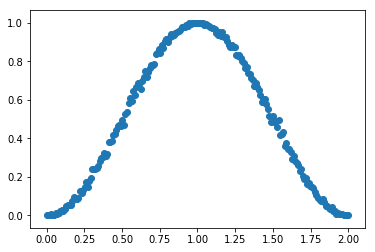

In [10]:
q = cirq.GridQubit(1,1)
circuit = cirq.Circuit(cirq.X(q)**sympy.Symbol('t'), cirq.measure(q,key='m'))

param_sweep = cirq.Linspace('t', start=0, stop=2, length=200)

s = cirq.Simulator()
trials = s.run_sweep(circuit, param_sweep, repetitions=1000)


x_data = [trial.params['t'] for trial in trials]
y_data = [trial.histogram(key='m')[1]/1000.0 for trial in trials]
plt.scatter('t','p', data={'t': x_data, 'p': y_data})

Note the qubit is always initialized to 0. Applying $\sigma_x^0=\sigma_x^2=\mathbb{I}$ gives 0, while applying $\sigma_x^1$ gives 1.

It is also sometimes helpful to print the unitary matrix corresponding to a set of gates (recall qubit gates are always unitary). For a single qubit, this is represted in the $(0,1)^T$ basis, for 2 qubits, it is represnted in the $(00,01,10,11)^T$ basis.

In [11]:
print(cirq.unitary(cirq.X))
print()
q0, q1 = cirq.LineQubit.range(2)
print(cirq.unitary(cirq.SWAP(q0,q1)))
print()
print(cirq.unitary(cirq.Circuit(cirq.X(q0),cirq.SWAP(q0,q1))))

[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]

[[0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]


There are also optimization functions in Cirq that merge multiple consecutive gates into one unitary.

In [12]:
q = cirq.GridQubit(1,1)
optimizer = cirq.MergeSingleQubitGates()
c = cirq.Circuit(cirq.X(q)**0.25, cirq.Y(q)**0.25,cirq.Z(q)**0.25)
print(c)
optimizer.optimize_circuit(c)
print(c)

(1, 1): ───X^0.25───Y^0.25───T───
           ┌                           ┐
(1, 1): ───│ 0.5  +0.707j -0.   -0.5j  │───────────
           │ 0.354+0.354j  0.146+0.854j│
           └                           ┘


# Example: Spin-1/2 in a magnetic field

Let's construct a circuit that time-evolves a single spin-1/2 in a rotating magnetic field. The Hamiltonian is
\begin{eqnarray}
\mathcal{H}(t)=\vec{H}(t)\cdot\vec{\sigma},
\end{eqnarray}
for the magnetic field $\vec{H}(t)=H(\sin\theta(t),0,\cos\theta(t))$.

We cannot continuously change the magnetic field in a quantum circuit, so we have to do this through a series of gates. The way we implement this is a Trotter decmoposition. Setting $\hbar=1$, the time-evolution operator is written as
\begin{eqnarray}
U(t_f,t_0)&=&e^{-i\int^{t_f}_{t_0}\mathcal{H}(t')dt'}\\
&=&e^{-i\sum_{j=0}^N\mathcal{H}(t_j)\Delta t},
\end{eqnarray}
where we have divided the time interval into $N$ steps of width $\Delta t=\frac{t_f-t_0}{N}$. 

Recall that $e^{\Delta t(A+B)}=e^{\Delta tA}e^{\Delta tB}+\mathcal{O}((\Delta t)^2[A,B])$, so for $N$ sufficiently large, we can ignore the commutator terms in the time-evolution operator. This allows us to write
\begin{eqnarray}
U(t_f,t_0)&\approx&\Pi_{j=0}^Ne^{-i\Delta t H\sin\theta(t_j)\sigma_x}e^{-i\Delta t H\cos\theta(t_j)\sigma_z}
&=&\Pi_{j=0}^Ng_x(t_j)g_z(t_j),
\end{eqnarray}
where we have defined $g_x(t_j)$ and $g_z(t_j)$, the two rotation gates that will be applied in our circuit.

First we initialize our qubit and circuit:

In [13]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import sympy

q0 = cirq.LineQubit(1)
c = cirq.Circuit()
optimizer = cirq.MergeSingleQubitGates()

Now we implement the Trotter decomposition. Here is a simple example with 2 steps. Note that our $g_x$ and $g_z$ gates are rotation operators. In Cirq the rotation gate $e^{i\frac{\phi}{2}\sigma_x}$ is implemented using cirq.rx(rads=$\phi$) and likewise for $\sigma_z$

In [14]:
Nsteps = 2
H = 1
v = 0.04 # Velocity of the magnetic field sweep
tfinal = np.pi/v # Here we sweep from theta=0 to pi
delt = tfinal/Nsteps
for step in range(Nsteps):
    theta = step/Nsteps*np.pi
    gz = cirq.rz(rads=-2*delt*(H*np.cos(theta))) #factor of 2 because rotation defined /2
    gx = cirq.rx(rads=-2*delt*(H*np.sin(theta)))
    c.append(gz(q0))
    c.append(gx(q0))

c.append(cirq.measure(q0, key='sz'))
print(c)

s = cirq.Simulator()
result = s.run(c)
print(result)

1: ───Rz(-π)───Rx(0)───Rz(0)───Rx(-π)───M('sz')───
sz=1


This simple 2-step decomposition has sucessfully flipped the spin. To see that the spin rotates with the magnetic field we can vary tfinal between 0 and $\pi/v$ and plot the measurements. Note that a qubit measurement of 0 is interpreted as spin up, while a measurement of 1 is interpreted as spin down.

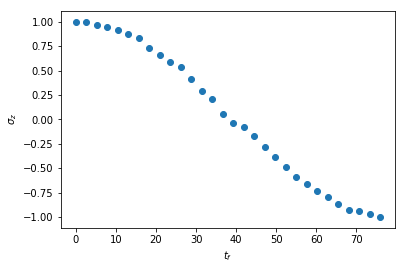

In [15]:
Nsteps = 200
H = 1
v = 0.04 # Velocity of the magnetic field sweep
tfinal = 0.0
x_data = []
y_data = []
while tfinal<np.pi/v:
    q0 = cirq.LineQubit(1)
    c = cirq.Circuit()
    optimizer = cirq.MergeSingleQubitGates()
    delt = tfinal/Nsteps
    for step in range(Nsteps):
        theta = step/Nsteps*v*tfinal
        gz = cirq.rz(rads=-2*delt*(H*np.cos(theta)))
        gx = cirq.rx(rads=-2*delt*(H*np.sin(theta)))
        c.append(gz(q0))
        c.append(gx(q0))

    c.append(cirq.measure(q0, key='sz'))
    optimizer.optimize_circuit(c)

    s = cirq.Simulator()
    reps = 900
    result = s.run(c,repetitions=reps)
    sigmaz = (result.histogram(key='sz')[0]-result.histogram(key='sz')[1])/reps

    x_data.append(tfinal)
    y_data.append(sigmaz)
    tfinal += (np.pi/v)/30.0

plt.xlabel("$t_f$")
plt.ylabel("$\sigma_z$")
plt.scatter('x','y', data={'x': x_data, 'y': y_data})
plt.show()

# Exercise: Two coupled qubits

Implement the Trotter decomposition of the 2-qubit Hamiltonian
\begin{eqnarray}
\mathcal{H}(t)=\vec{H}(t)\cdot\vec{\sigma}^1 + r\sigma_z^1\sigma_z^2.
\end{eqnarray}

Plot $\langle\sigma_z^2(t)\rangle$. 

Plot $\langle\sigma_z^2(t_f)\rangle$ as a function of $r$.

Hint: You will need to use the two-qubit parity gate cirq.ZZPowGate() with the right exponent and global shift: https://cirq.readthedocs.io/en/stable/generated/cirq.ZZPowGate.html